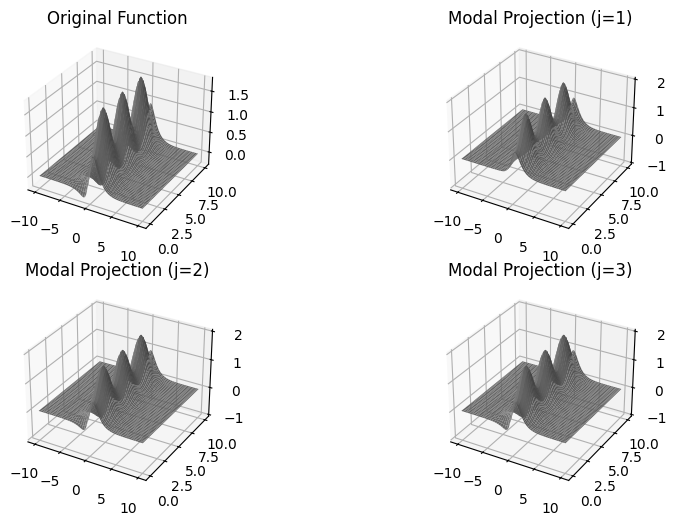

(500, 100)
(500, 100)
(500, 100)


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Create arrays x and t
x = np.linspace(-10, 10, 100)
t = np.linspace(0, 10, 500)

# Create meshgrid
X, T = np.meshgrid(x, t)

# Calculate function f
f = np.cosh(X) ** -1 * (1 - 0.5 * np.cos(2 * T)) + (np.cosh(X) ** -1 * np.tanh(X)) * (1 - 0.5 * np.sin(2 * T))

# Plot original function f
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
ax1.plot_surface(X, T, f, color='gray')
ax1.set_title("Original Function")

# Perform SVD
u, s, v = np.linalg.svd(f.T)

# Plot modal projections
for j in range(3):
    ff = np.dot(u[:, :j+1], np.dot(np.diag(s[:j+1]), v[:j+1, :]))
    ax = fig.add_subplot(2, 2, j+2, projection='3d')
    ax.plot_surface(X, T, ff.T, color='gray')
    ax.set_zlim(-1, 2)
    ax.set_title(f"Modal Projection (j={j+1})")

plt.show()

print(T.shape)
print(X.shape)
print(ff.T.shape)

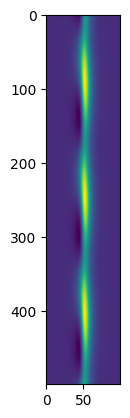

In [2]:
from processdata import load_data
from processdata import TimeSeriesDataset
import models
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

num_sensors = 3 
lags = 52
load_X = f

n = load_X.shape[0]
m = load_X.shape[1]
sensor_locations = np.random.choice(m, size=num_sensors, replace=False)
load_X.shape  # time (n), space (m)

plt.imshow(load_X)


In [3]:
train_indices = np.random.choice(n - lags, size=50, replace=False)
mask = np.ones(n - lags)
mask[train_indices] = 0
valid_test_indices = np.arange(0, n - lags)[np.where(mask!=0)[0]]
valid_indices = valid_test_indices[::2]
test_indices = valid_test_indices[1::2]

In [4]:
sc = MinMaxScaler()
sc = sc.fit(load_X[train_indices])
transformed_X = sc.transform(load_X)

### Generate input sequences to a SHRED model
all_data_in = np.zeros((n - lags, lags, num_sensors))
for i in range(len(all_data_in)):
    all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

### -1 to have output be at the same time as final sensor measurements
train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

In [5]:
shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=1000, lr=1e-3, verbose=True, patience=5)

Training epoch 1
Error tensor(0.9861)
Training epoch 20
Error tensor(0.5685)
Training epoch 40
Error tensor(0.4974)
Training epoch 60
Error tensor(0.4248)
Training epoch 80
Error tensor(0.4007)
Training epoch 100
Error tensor(0.1670)
Training epoch 120
Error tensor(0.0746)
Training epoch 140
Error tensor(0.0371)
Training epoch 160
Error tensor(0.0409)
Training epoch 180
Error tensor(0.0172)
Training epoch 200
Error tensor(0.0306)
Training epoch 220
Error tensor(0.0175)
Training epoch 240
Error tensor(0.0215)
Training epoch 260
Error tensor(0.0224)
Training epoch 280
Error tensor(0.0265)


In [6]:
test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
print(np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth))

0.013451337


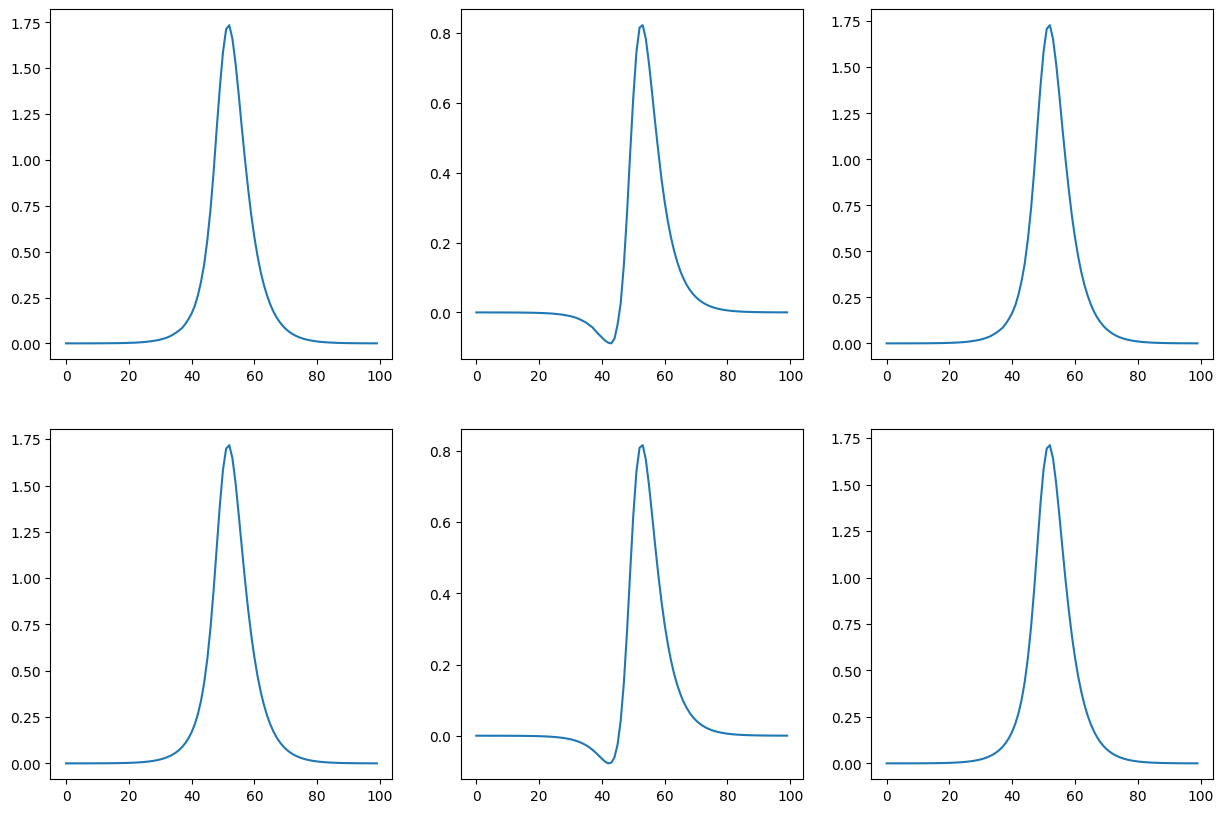

In [7]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(2, 3, 1)
plt.plot(test_recons[10])
ax = fig.add_subplot(2, 3, 4)
plt.plot(test_ground_truth[10])
ax = fig.add_subplot(2, 3, 2)
plt.plot(test_recons[50])
ax = fig.add_subplot(2, 3, 5)
plt.plot(test_ground_truth[50])
ax = fig.add_subplot(2, 3, 3)
plt.plot(test_recons[150])
ax = fig.add_subplot(2, 3, 6)
plt.plot(test_ground_truth[150])

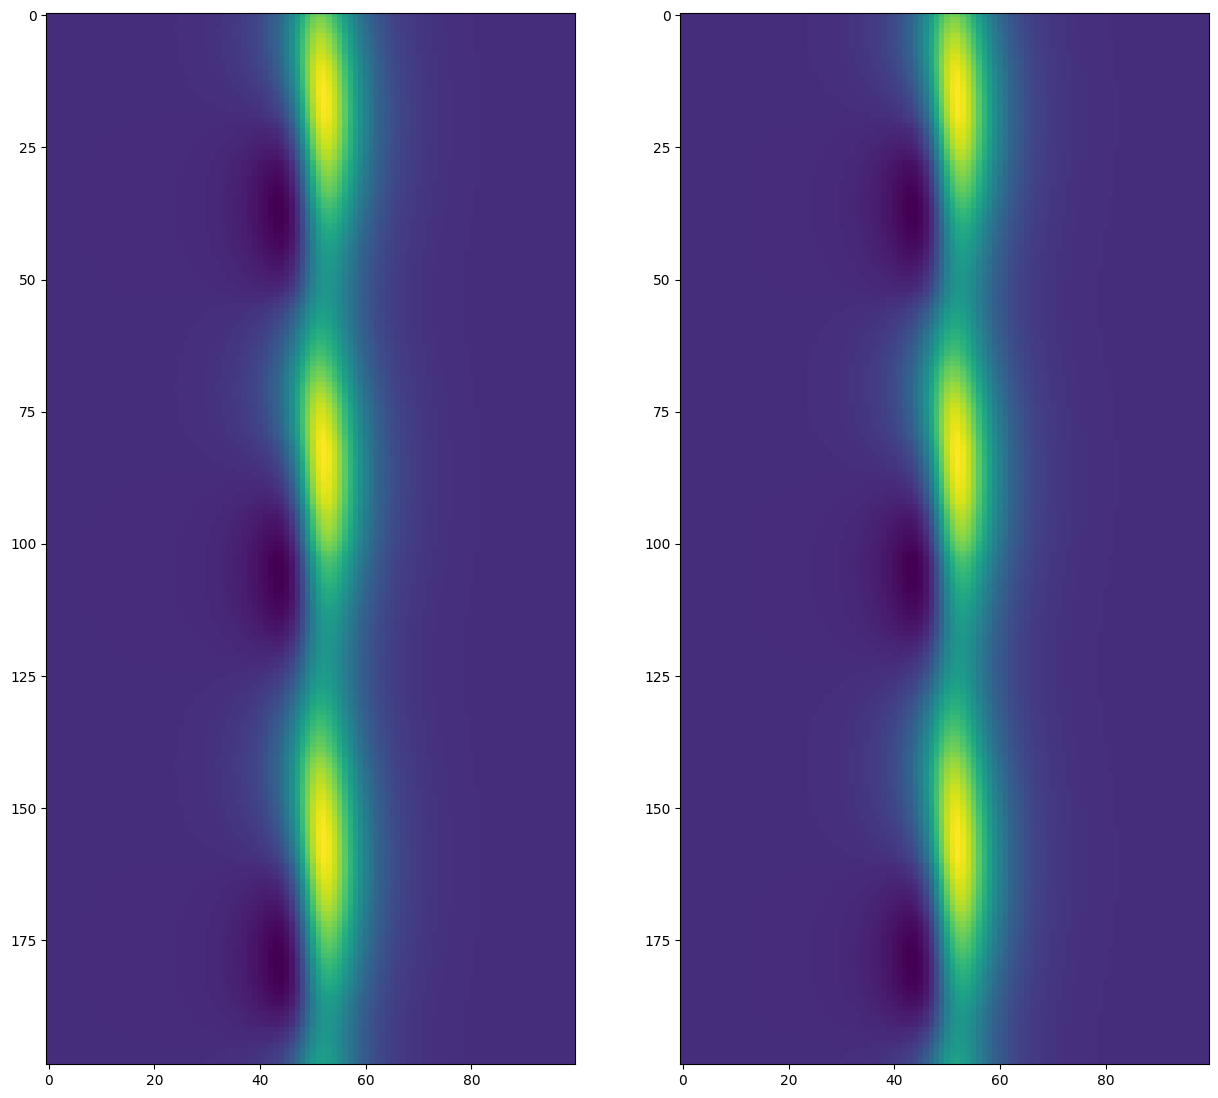

In [8]:
fig = plt.figure(figsize=(15, 50))
ax = fig.add_subplot(1, 2, 1)
plt.imshow(test_recons)
ax = fig.add_subplot(1, 2, 2)
plt.imshow(test_ground_truth)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


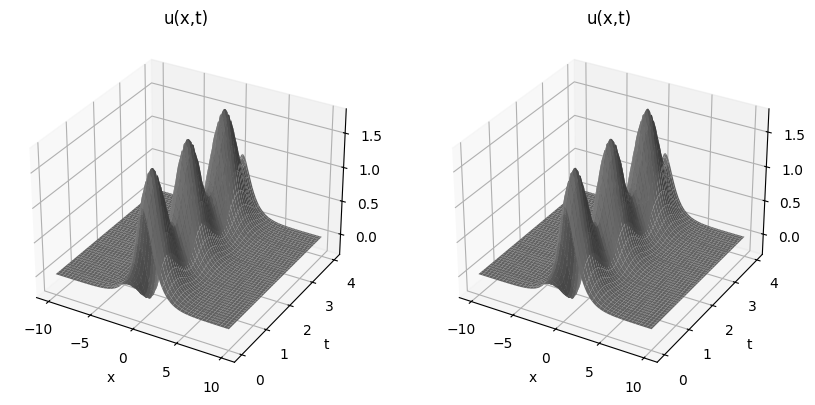

In [15]:

fig = plt.figure(figsize=(10, 6))
T2 = T[:199,:]
X2 = X[:199,:]

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(X2, T2, test_recons, color='gray')

plt.xlabel('x')
plt.ylabel('t')
plt.title('u(x,t)')

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_surface(X2, T2, test_ground_truth, color='gray')

plt.xlabel('x')
plt.ylabel('t')
plt.title('u(x,t)')

plt.savefig('shred3.eps', format='eps')
plt.show()



<Figure size 640x480 with 0 Axes>